# Circos plot for gene-gene interaction

## Description

This notebook is used to generate circos plot for, but not limited to, gene-gene interaction. In fact, as long as the expected schema (see below) is respected, you can plot any interactions that follow more or less the same logic. The input file should be a dataframe (currently .csv, more will be added), which includes the following categorical columns:
- Exactly one "Interaction" column (required).
- "Metadata" column(s), used for adding categorical feature annotation to the genes.

And the following numerical columns:

- "Weight" column, used for the width of the interaction line. In the case of gene-gene interaction, it is the binding score.

The output file is a circos plot (PNG, PDF, SVG, etc.), roughly resembling the example plot below.

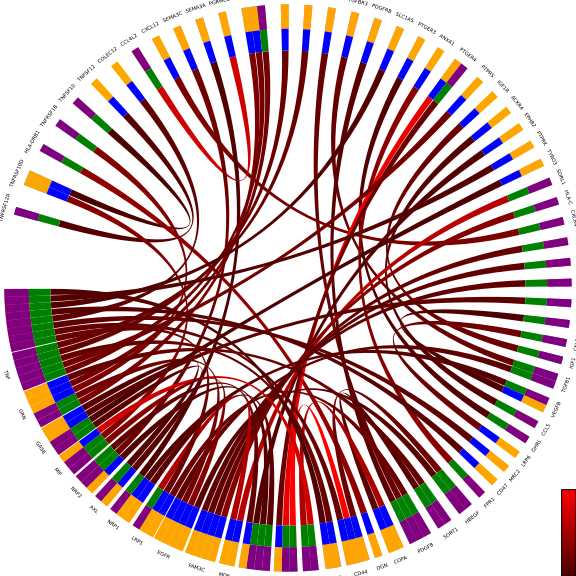

In [1]:
from IPython.display import SVG, display
plot_fn = '/home/jovyan/pyCircos/example_notebooks/fca_circPlot.svg'
SVG(filename=plot_fn)
# IFrame(plot_fn, width=500, height=500)

## Anatomy of the data, workflow and visualization

Currently

In [2]:
%matplotlib inline

In [15]:
import pycircos
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from pathlib import Path
import os

Setting up figure object and its resolution.

In [10]:
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle
plt.rcParams['figure.dpi'] = 300

In [11]:
fca_path = '/home/jovyan/FCA_Fetal_Skin_priv/'

In [44]:
dfs = [pd.read_csv(Path(fca_path, "data", f)) for f in Path(fca_path, "data").glob('*.csv')]
df = pd.concat(dfs)
fca_df_raw = df[df['gene_pair'].isin(df["Interactions to show"].dropna().unique())]
fca_df = pd.concat([fca_df_raw, fca_df_raw.gene_pair.str.split('|', expand=True).rename(columns={0:'gene_1', 1:'gene_2'})], axis=1).drop(columns=['gene_pair'])
fca_df = pd.concat([fca_df_raw, fca_df_raw.gene_pair.str.split('|', expand=True).rename(columns={0:'gene_1', 1:'gene_2'})], axis=1).drop(columns=['gene_pair'])
cols = fca_df_raw.columns.to_list()
cols.remove("Interactions to show")
print(cols)
fca_df_raw = fca_df_raw[cols]
fca_df_raw

gene_pair                        celltype_pair   mean      p      padj
0    CXCL12|DPP4           Pre-dermal condensate|ILC2  1.024  0.000  0.000000
1     CXCL2|DPP4           Pre-dermal condensate|ILC2  0.307  0.000  0.000000
2   CXCL12|CXCR4           Pre-dermal condensate|ILC2  1.754  0.000  0.000000
3    CXCL12|DPP4            Pre-dermal condensate|LTi  0.987  0.000  0.000000
4     CXCL2|DPP4            Pre-dermal condensate|LTi  0.270  0.006  0.448125
..           ...                                  ...    ...    ...       ...
1   PDGFB|PDGFRB  LYVE1++ macrophage|WNT2+ fibroblast  0.306  0.000  0.000000
2   PDGFB|PDGFRA  LYVE1++ macrophage|WNT2+ fibroblast  0.438  0.000  0.000000
3       GRN|EGFR  LYVE1++ macrophage|WNT2+ fibroblast  0.702  0.000  0.000000
4   PDGFC|PDGFRA  LYVE1++ macrophage|WNT2+ fibroblast  0.403  0.000  0.000000
5     CSF1|CSF1R  WNT2+ fibroblast|LYVE1++ macrophage  0.945  0.000  0.000000

[82 rows x 5 columns]

In [47]:
fca_df_raw['celltype_pair'].unique()

array(['Pre-dermal condensate|ILC2', 'Pre-dermal condensate|LTi',
       'ILC3|HOXC5+ early fibroblast', 'ILC3|Immature basal',
       'ILC3|Basal', 'ILC3|POSTN+ basal',
       'Pre-dermal condensate|Immature basal', 'Dermal condensate|Basal',
       'Dermal condensate|Companion layer',
       'Dermal condensate|Cuticle/cortex',
       'Dermal condensate|Inner root sheath',
       'Dermal condensate|Matrix/placode',
       'Dermal condensate|Outer root sheath',
       'Dermal condensate|POSTN+ basal', 'Dermal papillia|Basal',
       'Dermal papillia|Companion layer',
       'Dermal papillia|Cuticle/cortex',
       'Dermal papillia|Inner root sheath',
       'Dermal papillia|Matrix/placode',
       'Dermal papillia|Outer root sheath',
       'Dermal papillia|POSTN+ basal',
       'LYVE1++ macrophage|WNT2+ fibroblast',
       'WNT2+ fibroblast|LYVE1++ macrophage'], dtype=object)

In [46]:
# Assign the second gene's (ligand_y) molecule type
ligand_y = []
for l in fca_df_raw.Ligand:
    if l == 'Ligand':
        ligand_y.append('Receptor')
    else:
        ligand_y.append('Ligand')
fca_df = pd.concat([fca_df_raw, fca_df_raw.gene_pair.str.split('|', expand=True).rename(columns={0:'gene_1', 1:'gene_2'})], axis=1).drop(columns=['gene_pair'])
fca_df['gene_1_count'] = fca_df.groupby('gene_1')['gene_1'].transform('count')
fca_df['gene_2_count'] = fca_df.groupby('gene_2')['gene_2'].transform('count')
fca_df = pd.concat([fca_df, fca_df.celltype_pair.str.split('|', expand=True).rename(columns={0:'celltype_1', 1:'celltype_2'})], axis=1).drop(columns=['celltype_pair'])
fca_df.Ligand = fca_df.Ligand.str.split(': ', expand=True)[1]
fca_df['Ligand_x'] = fca_df.Ligand
fca_df['Ligand_y'] = ligand_y
a, b = 75, 255
x, y = fca_df['mean'].min(), fca_df['mean'].max()
fca_df['normal_mean'] = (fca_df['mean'] - x) / (y - x) * (b - a) + a
fca_df['normal_mean'] = fca_df['normal_mean'].astype(int)
fca_df['unique_id'] = fca_df.gene_1.astype(str) + '_' + fca_df.gene_2.astype(str) + '_' + fca_df['mean'].astype(str)
fca_df

AttributeError: 'DataFrame' object has no attribute 'Ligand'

<span style="font-family:Times New Roman; font-size:1.3em; color:salmon">Check if the gene pairs are unique</span>

In [4363]:
uni_genes = list(pd.concat([pd.Series(fca_df.gene_1.unique()), pd.Series(fca_df.gene_2.unique())]).unique())
unique_genes = dict()
for g in uni_genes:
    count_1 = 0
    count_2 = 0
    if g in fca_df['gene_1'].to_list():
        count_1 = fca_df[fca_df['gene_1']==g]['gene_1_count'].to_list()[0]
    if g in fca_df['gene_2'].to_list():
        count_1 = fca_df[fca_df['gene_2']==g]['gene_2_count'].to_list()[0]
    unique_genes[g] = (count_1+count_2)-len(g)
unique_genes = {k: v for k, v in sorted(unique_genes.items(), key=lambda item: item[1])}
unique_genes = list(unique_genes.keys())

In [4364]:
crossref_ls = []
for i in fca_df['gene_1'].unique():
    if i in fca_df['gene_2'].unique():
        crossref_ls.append(i)
crossref_ls

['CD44', 'EGFR']

In [4365]:
fca_df[(fca_df['gene_1'].str.contains('CD44')) | 
       (fca_df['gene_1'].str.contains('EGFR')) | 
       (fca_df['gene_2'].str.contains('EGFR')) | 
       (fca_df['gene_2'].str.contains('CD44'))]

mean    p  padj    Ligand               Fib  gene_1 gene_2  gene_1_count  \
0   2.560  0.0   0.0    Ligand  WNT2+ fibroblast    SPP1   CD44             3   
3   0.892  0.0   0.0    Ligand  WNT2+ fibroblast     MIF   EGFR             3   
8   0.628  0.0   0.0    Ligand  WNT2+ fibroblast     GRN   EGFR             5   
18  0.454  0.0   0.0    Ligand  WNT2+ fibroblast  LGALS9   CD44             8   
21  0.337  0.0   0.0    Ligand  WNT2+ fibroblast   TGFB1   EGFR             2   
47  0.580  0.0   0.0  Receptor  WNT2+ fibroblast    CD44  HBEGF             1   
56  0.307  0.0   0.0  Receptor  WNT2+ fibroblast    EGFR  HBEGF             1   

    gene_2_count         celltype_1         celltype_2  Ligand_x  Ligand_y  \
0              2  TREM2+ macrophage   WNT2+ fibroblast    Ligand  Receptor   
3              3  TREM2+ macrophage   WNT2+ fibroblast    Ligand  Receptor   
8              3  TREM2+ macrophage   WNT2+ fibroblast    Ligand  Receptor   
18             2  TREM2+ macrophage   WNT2+ fibroblast    Ligand  Receptor   
21             3  TREM2+ macrophage   WNT2+ fibroblast    Ligand  Receptor   
47             2   WNT2+ fibroblast  TREM2+ macrophage  Receptor    Ligand   
56             2   WNT2+ fibroblast  TREM2+ macrophage  Receptor    Ligand   

    normal_mean          unique_id  
0           255     SPP1_CD44_2.56  
3           132     MIF_EGFR_0.892  
8           113     GRN_EGFR_0.628  
18          100  LGALS9_CD44_0.454  
21           92   TGFB1_EGFR_0.337  
47          109    CD44_HBEGF_0.58  
56           89   EGFR_HBEGF_0.307

In [4366]:
circle = Gcircle(figsize=(8,8)) 
for ind, g in enumerate(unique_genes):
    length = len(fca_df[(fca_df['gene_1'] == g) | 
                         (fca_df['gene_2'] == g)])
    length *= 10
    try:
        next_length = len(fca_df[(fca_df['gene_1'] == unique_genes[ind+1]) | 
                                 (fca_df['gene_2'] == unique_genes[ind+1])])
        next_length *= 10
        int_space = 0.2
        if len(g) > (length/10):
            if len(unique_genes[ind+1]) > (next_length/10):
                int_space = int_space+(((len(g))-(length/10))*0.3)+(((len(unique_genes[ind+1]))-(next_length/10))*0.3)
            else:
                int_space = int_space+(((len(g))-(length/10))*0.3)
    except IndexError:
        int_space = 0.2
    arc = Garc(arc_id=g, 
               size=length, 
               interspace=int_space, 
               raxis_range=(900,985), 
               labelposition=80, 
               label_visible=True, 
               labelsize=5, 
               linewidth=0)
    circle.add_garc(arc)

<Figure size 2400x2400 with 0 Axes>

In [4367]:
circle.set_garcs(-75,270) 

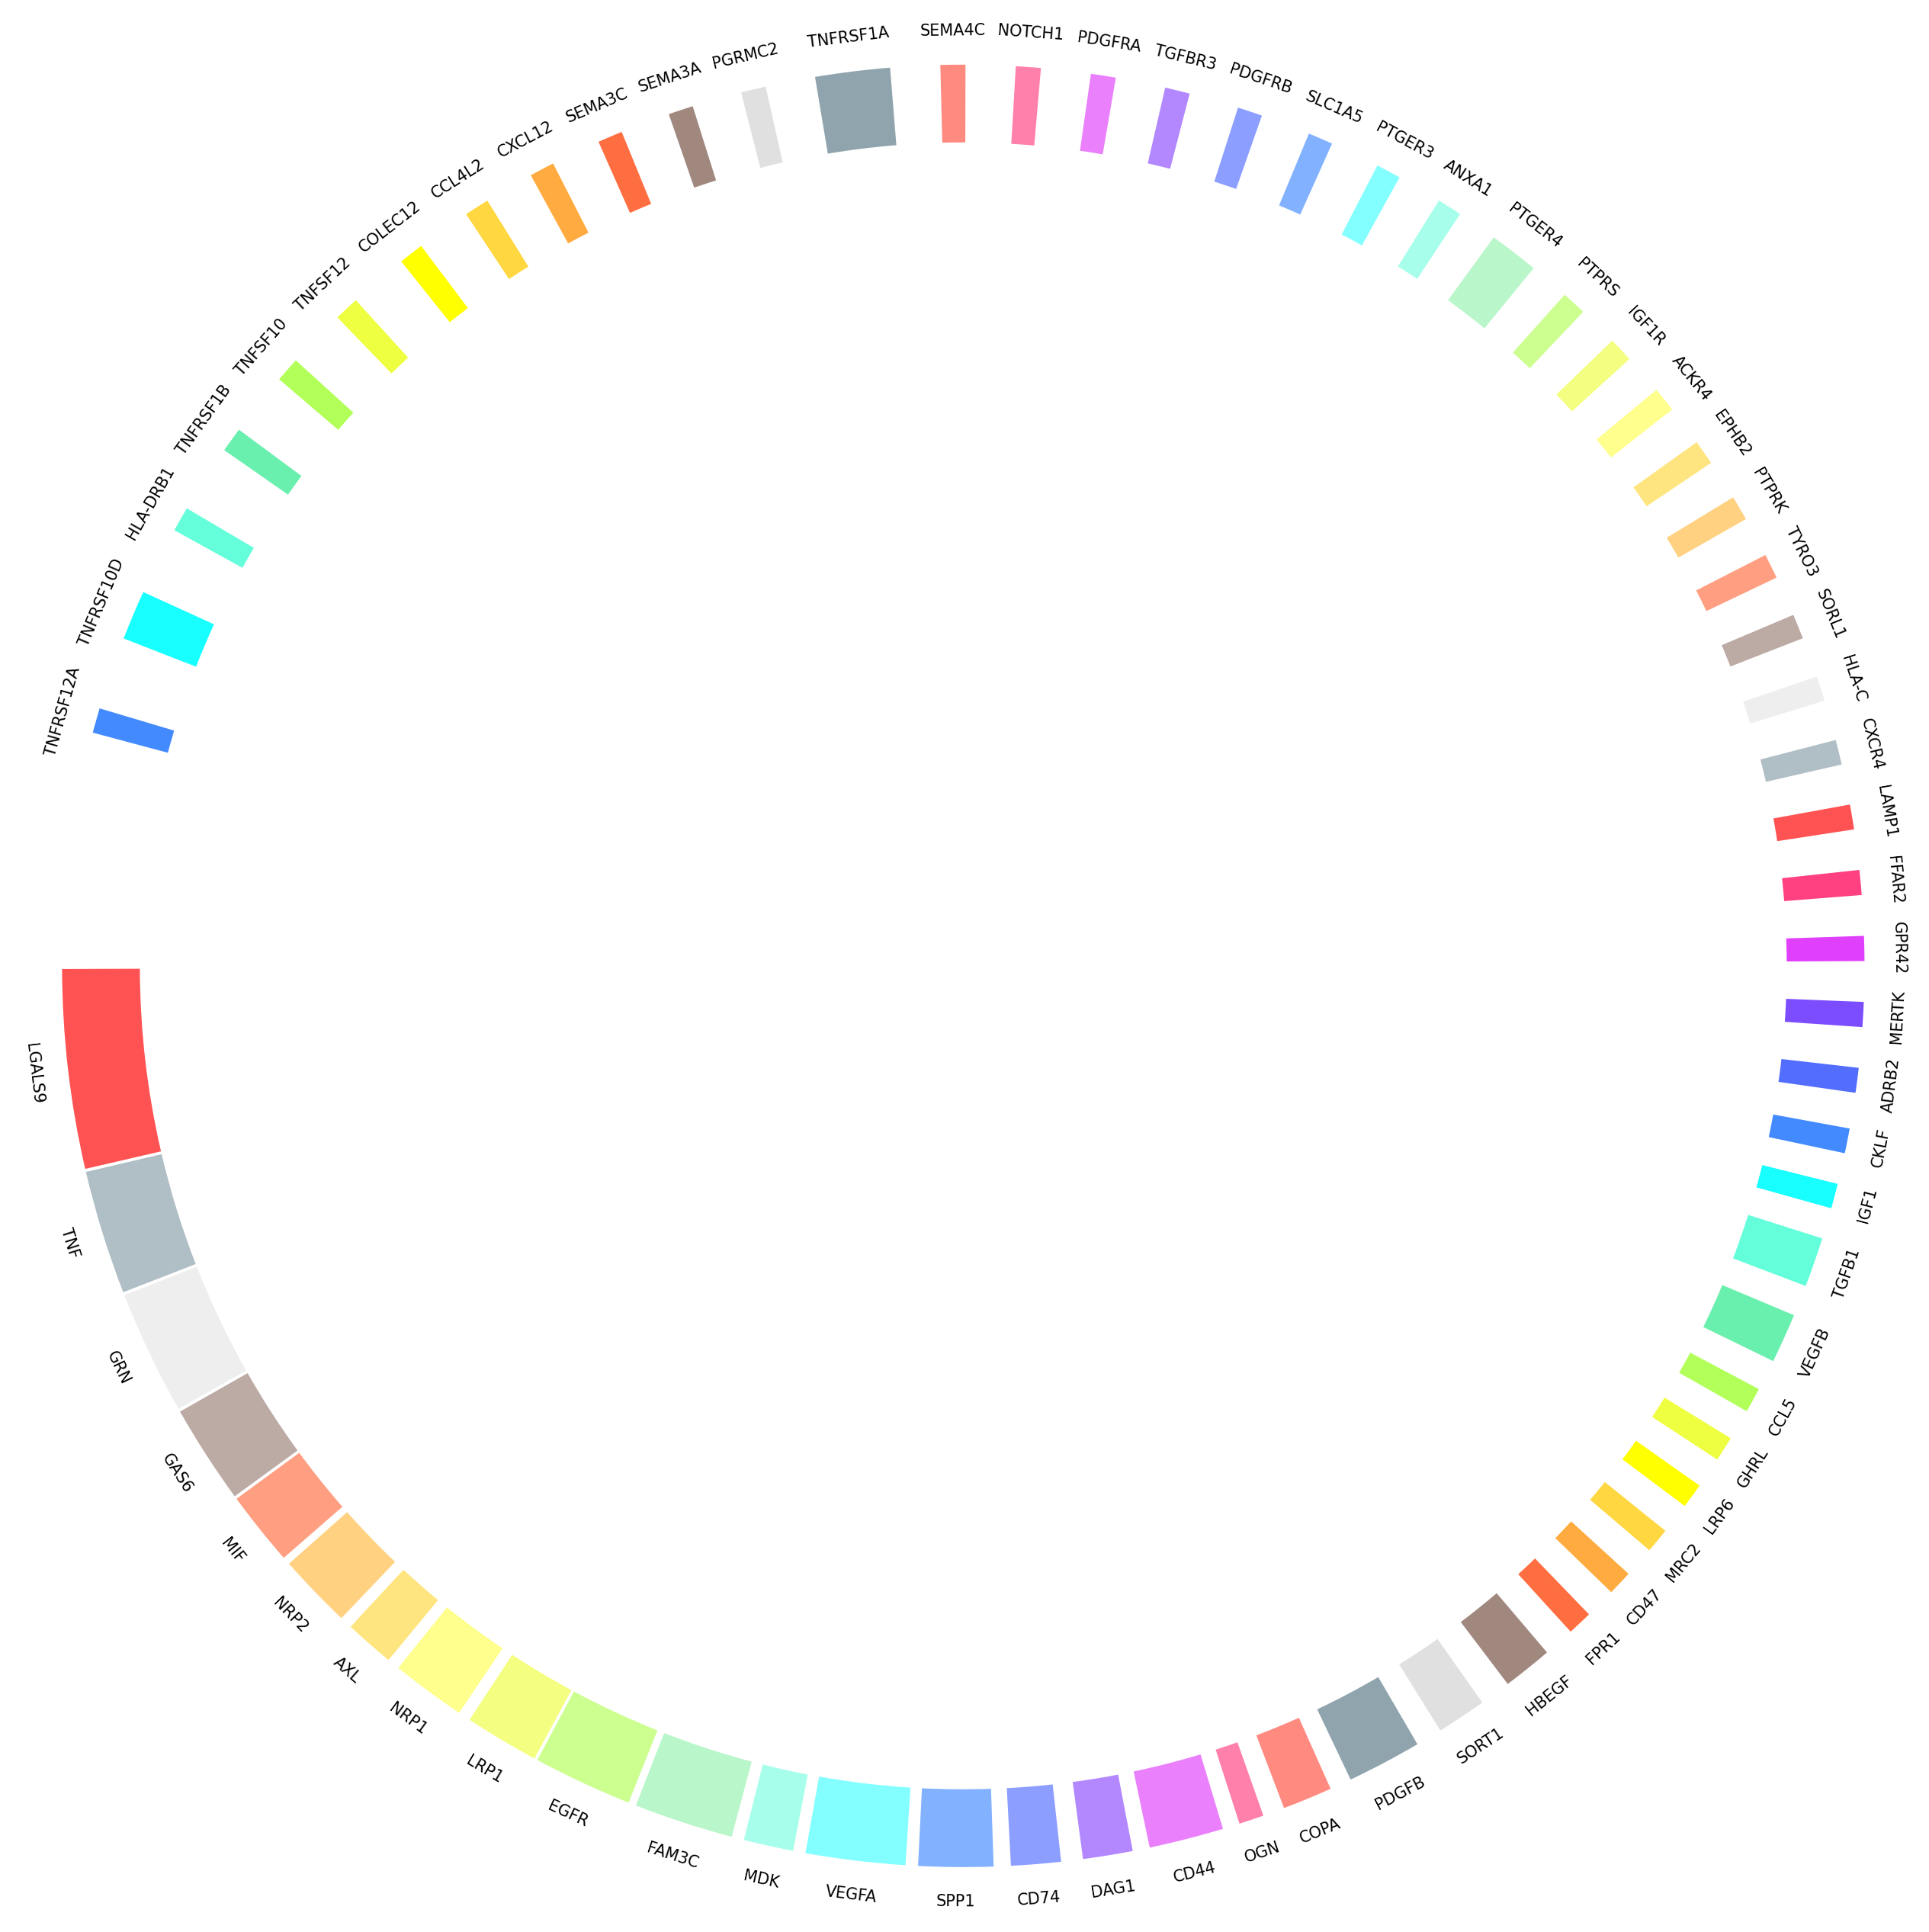

In [4368]:
circle.figure

In [4369]:
fca_bars_df = pd.concat([fca_df[['gene_1', 'gene_1_count', 'celltype_1', 'Ligand_x']].rename(columns={'gene_1':'gene', 
                                                                                              'gene_1_count':'gene_count', 
                                                                                              'celltype_1':'cell_type', 
                                                                                              'Ligand_x':'Ligand'}), 
                         fca_df[['gene_2', 'gene_2_count', 'celltype_2', 'Ligand_y']].rename(columns={'gene_2':'gene', 
                                                                                              'gene_2_count':'gene_count', 
                                                                                              'celltype_2':'cell_type', 
                                                                                              'Ligand_y':'Ligand'})])
fca_bars_df['gene_count'] = fca_bars_df.groupby('gene')['gene'].transform('count')
fca_bars_df['gene_count'] = fca_bars_df['gene_count'] + 1
fca_bars_df['normal_mean'] = pd.concat([fca_df['normal_mean'], fca_df['normal_mean']])
fca_bars_df['unique_id'] = pd.concat([fca_df['unique_id'], fca_df['unique_id']])
fca_bars_df['gene'] = fca_bars_df['gene'].astype('category')
fca_bars_df['gene'] = fca_bars_df['gene'].cat.set_categories(unique_genes, ordered=True)

In [4370]:
fca_bars_df

gene  gene_count          cell_type  Ligand  normal_mean  \
0        SPP1           4  TREM2+ macrophage  Ligand          255   
1        SPP1           4  TREM2+ macrophage  Ligand          234   
2      CCL4L2           2  TREM2+ macrophage  Ligand          208   
3         MIF           4  TREM2+ macrophage  Ligand          132   
4         MIF           4  TREM2+ macrophage  Ligand          132   
..        ...         ...                ...     ...          ...   
56      HBEGF           3  TREM2+ macrophage  Ligand           89   
57  TNFRSF12A           2  TREM2+ macrophage  Ligand           85   
58        AXL           3  TREM2+ macrophage  Ligand           85   
59       NRP1           4  TREM2+ macrophage  Ligand           81   
60      ADRB2           2  TREM2+ macrophage  Ligand           76   

                  unique_id  
0            SPP1_CD44_2.56  
1         SPP1_PTGER4_2.285  
2       CCL4L2_PGRMC2_1.922  
3            MIF_EGFR_0.892  
4       MIF_TNFRSF10D_0.889  
..                      ...  
56         EGFR_HBEGF_0.307  
57  TNFSF12_TNFRSF12A_0.242  
58            GAS6_AXL_0.24  
59        SEMA3A_NRP1_0.197  
60        VEGFB_ADRB2_0.129  

[122 rows x 6 columns]

In [4373]:
colour_dict = {"TREM2+ macrophage" : "purple", 
               "WNT2+ fibroblast" : "orange", 
               'Receptor' : "blue", 
               'Ligand' : "green"}
interaction_dict = collections.defaultdict(dict)
arcdata_dict = collections.defaultdict(dict)
for ind, g in enumerate(unique_genes):
    rec = circle._garc_dict[g].__dict__
    counter = len(fca_df[(fca_df['gene_1'] == g) | 
                         (fca_df['gene_2'] == g)])
    length = rec['size']
#     print(g, length)
    chunk = length/counter
    positions = np.arange(0, length+chunk, chunk)
#     print(g, len(positions))
    widths = [chunk for i in range(len(positions))]
#     print(g, len(widths))
    if g not in arcdata_dict:
        arcdata_dict[g]["positions"] = []
        arcdata_dict[g]["widths"] = [] 
        arcdata_dict[g]["colours_1"] = []
        arcdata_dict[g]["colours_2"] = []
        arcdata_dict[g]["Ligand"] = [] 
        arcdata_dict[g]["normal_mean"] = [] 
        arcdata_dict[g]["cell_type"] = []
    _counter = 0
    for i, row in fca_bars_df[fca_bars_df['gene']==g].iterrows():
        arcdata_dict[g]['cell_type'].append(row['cell_type'])
        arcdata_dict[g]['Ligand'].append(row['Ligand'])
        arcdata_dict[g]["colours_1"].append(colour_dict[row['cell_type']])
        arcdata_dict[g]["colours_2"].append(colour_dict[row['Ligand']])
        arcdata_dict[g]["normal_mean"].append(row['normal_mean'])
        arcdata_dict[g]['positions'].append(positions[_counter])
        arcdata_dict[g]['widths'].append(widths[_counter])
        if row['unique_id'] not in interaction_dict:
            interaction_dict[row["unique_id"]][g] = ()
        interaction_dict[row["unique_id"]][g] = (g, positions[_counter], positions[_counter]+widths[_counter]-1, 825)
#         if length == 2:
#             interaction_dict[row["unique_id"]][g] = (g, positions[_counter], positions[_counter]+widths[_counter]-1, 825)
#         else:
#             interaction_dict[row["unique_id"]][g] = (g, positions[_counter]-(1/length), positions[_counter]+(widths[_counter]-(1/length)), 825)
        _counter += 1
for key in arcdata_dict:
    circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[900,985], facecolor=arcdata_dict[key]["colours_1"])
for key in arcdata_dict:
    circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[825, 900], facecolor=arcdata_dict[key]["colours_2"])

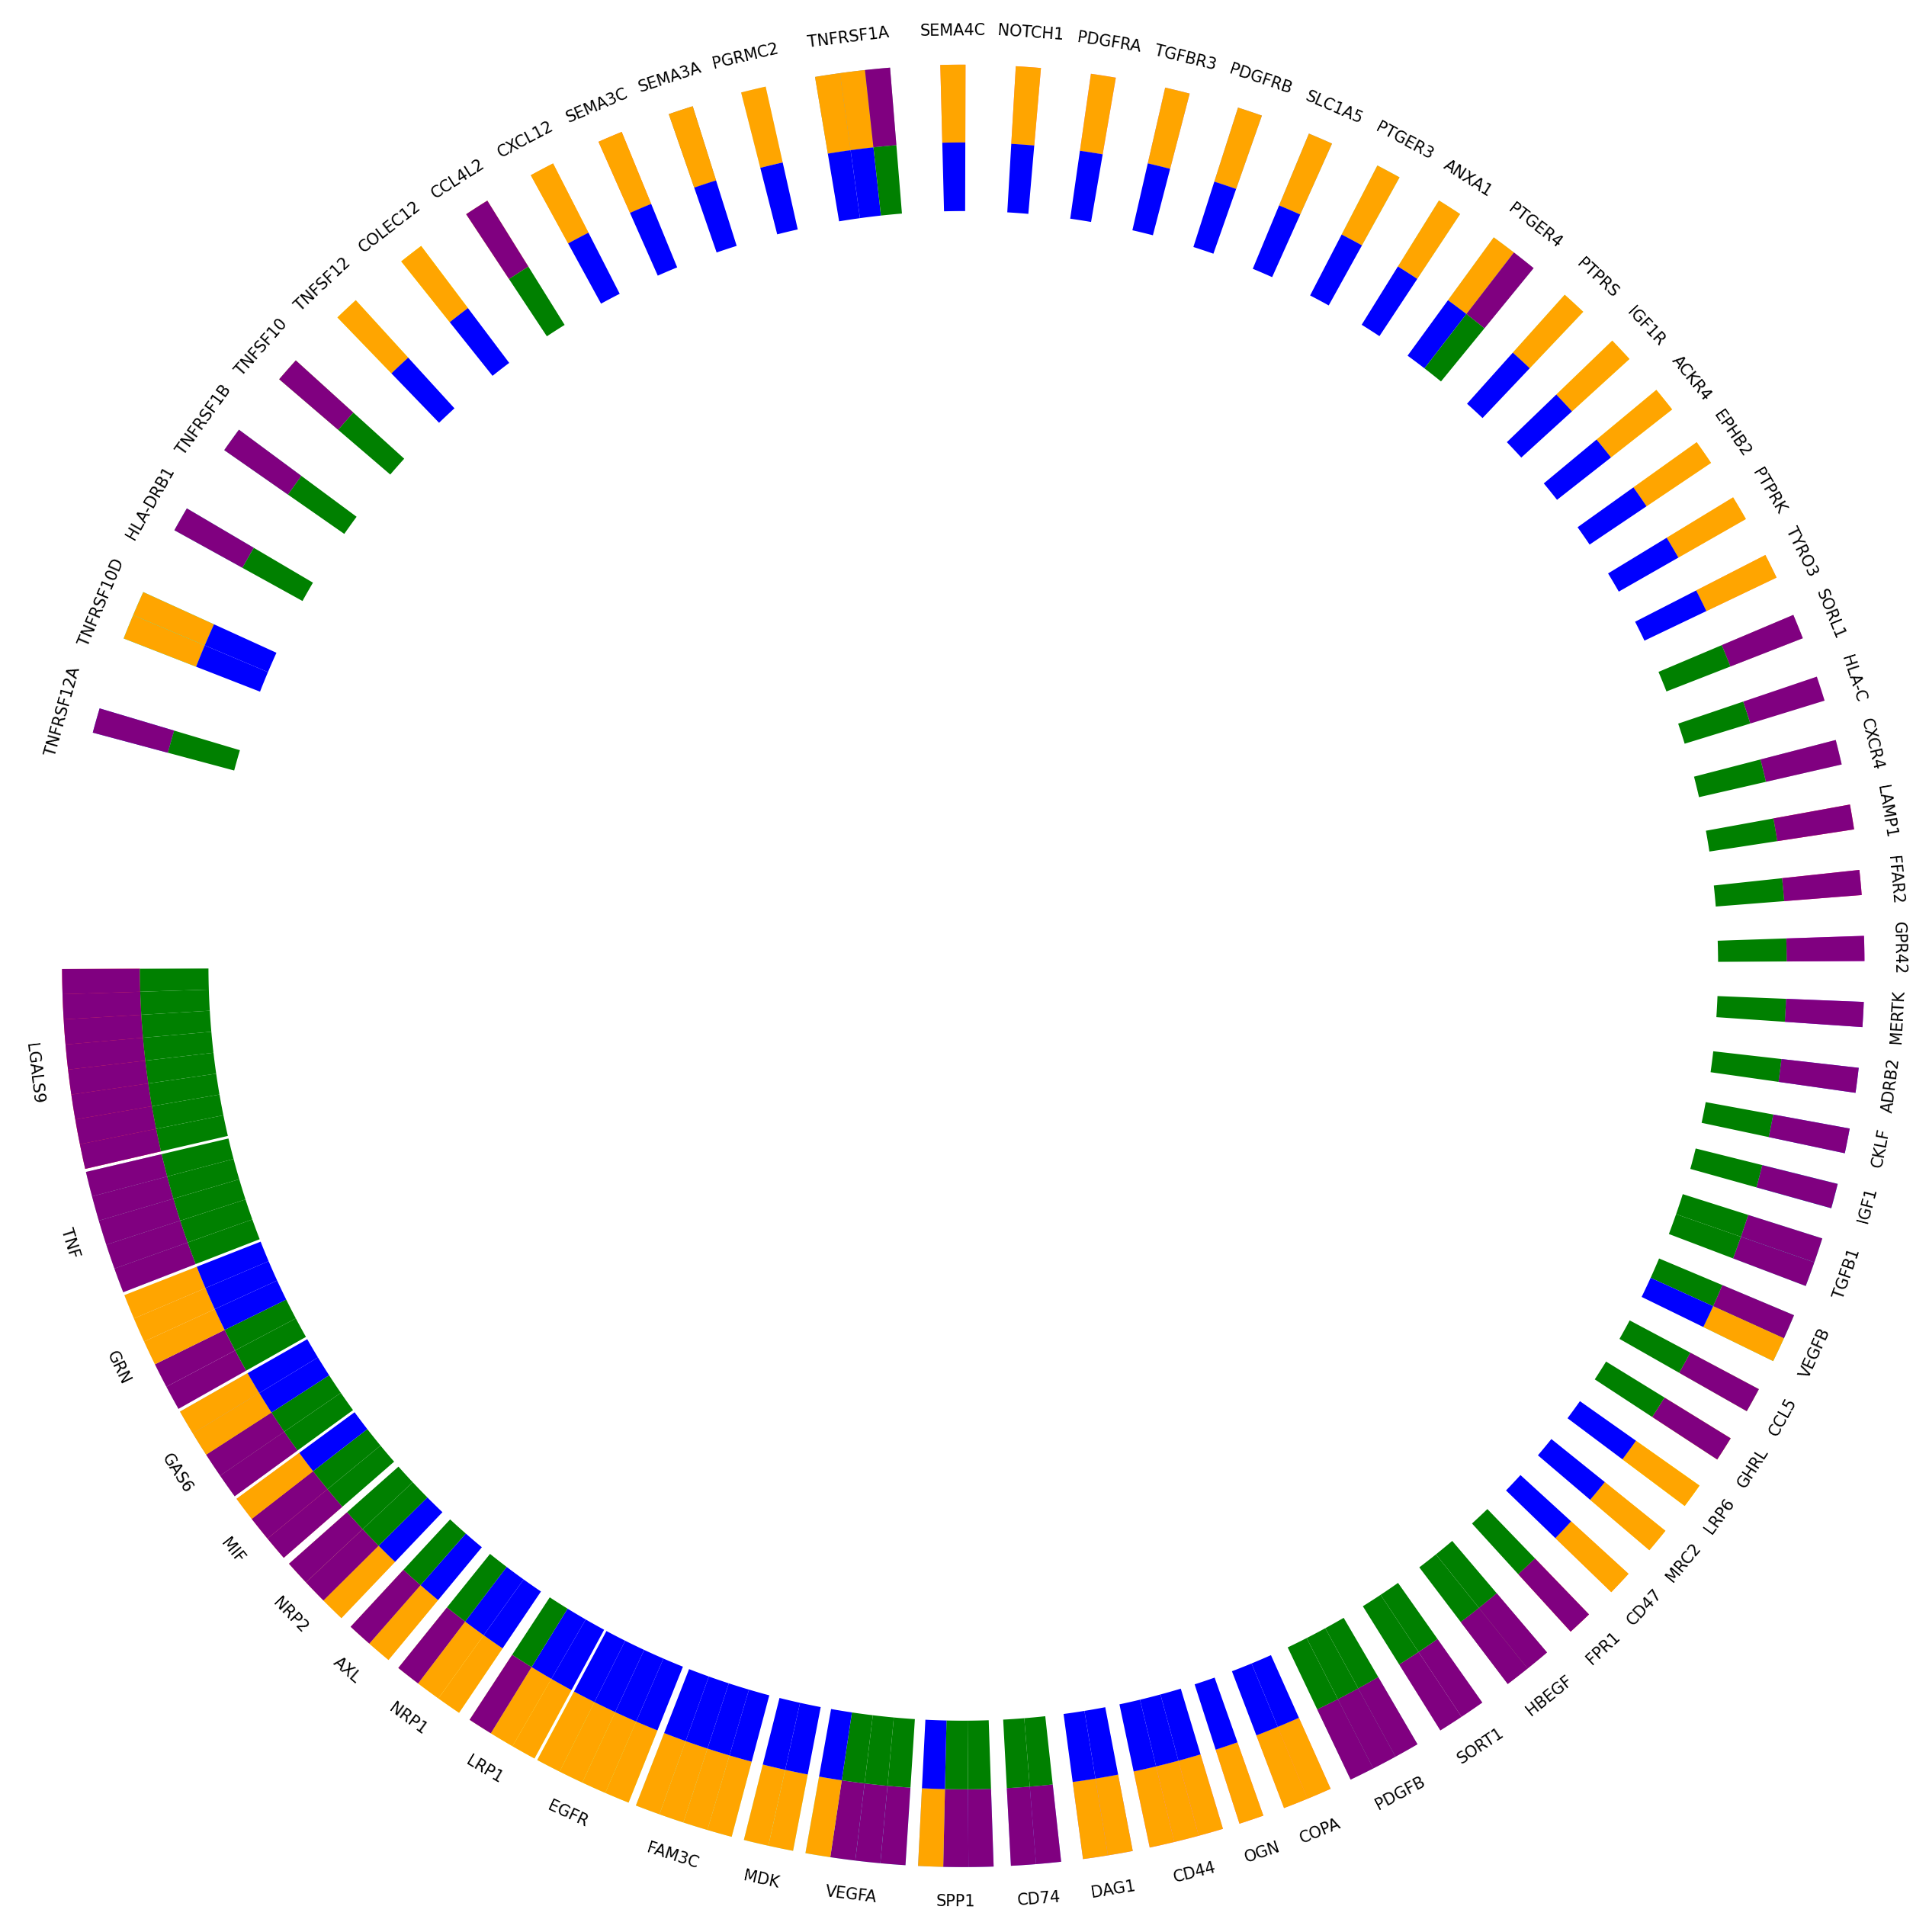

In [4375]:
circle.figure

In [4377]:
# circle.figure.savefig("fca_inter_circPlot.pdf")

In [4378]:
for k in interaction_dict:
    interactions = list(interaction_dict[k].values())
    source = interactions[0]
    destination = interactions[1]
    colour = int(fca_df[fca_df['unique_id']==k]['normal_mean'])
    circle.chord_plot(source, destination, facecolor='#%02x%02x%02x' % (colour, 0, 0))

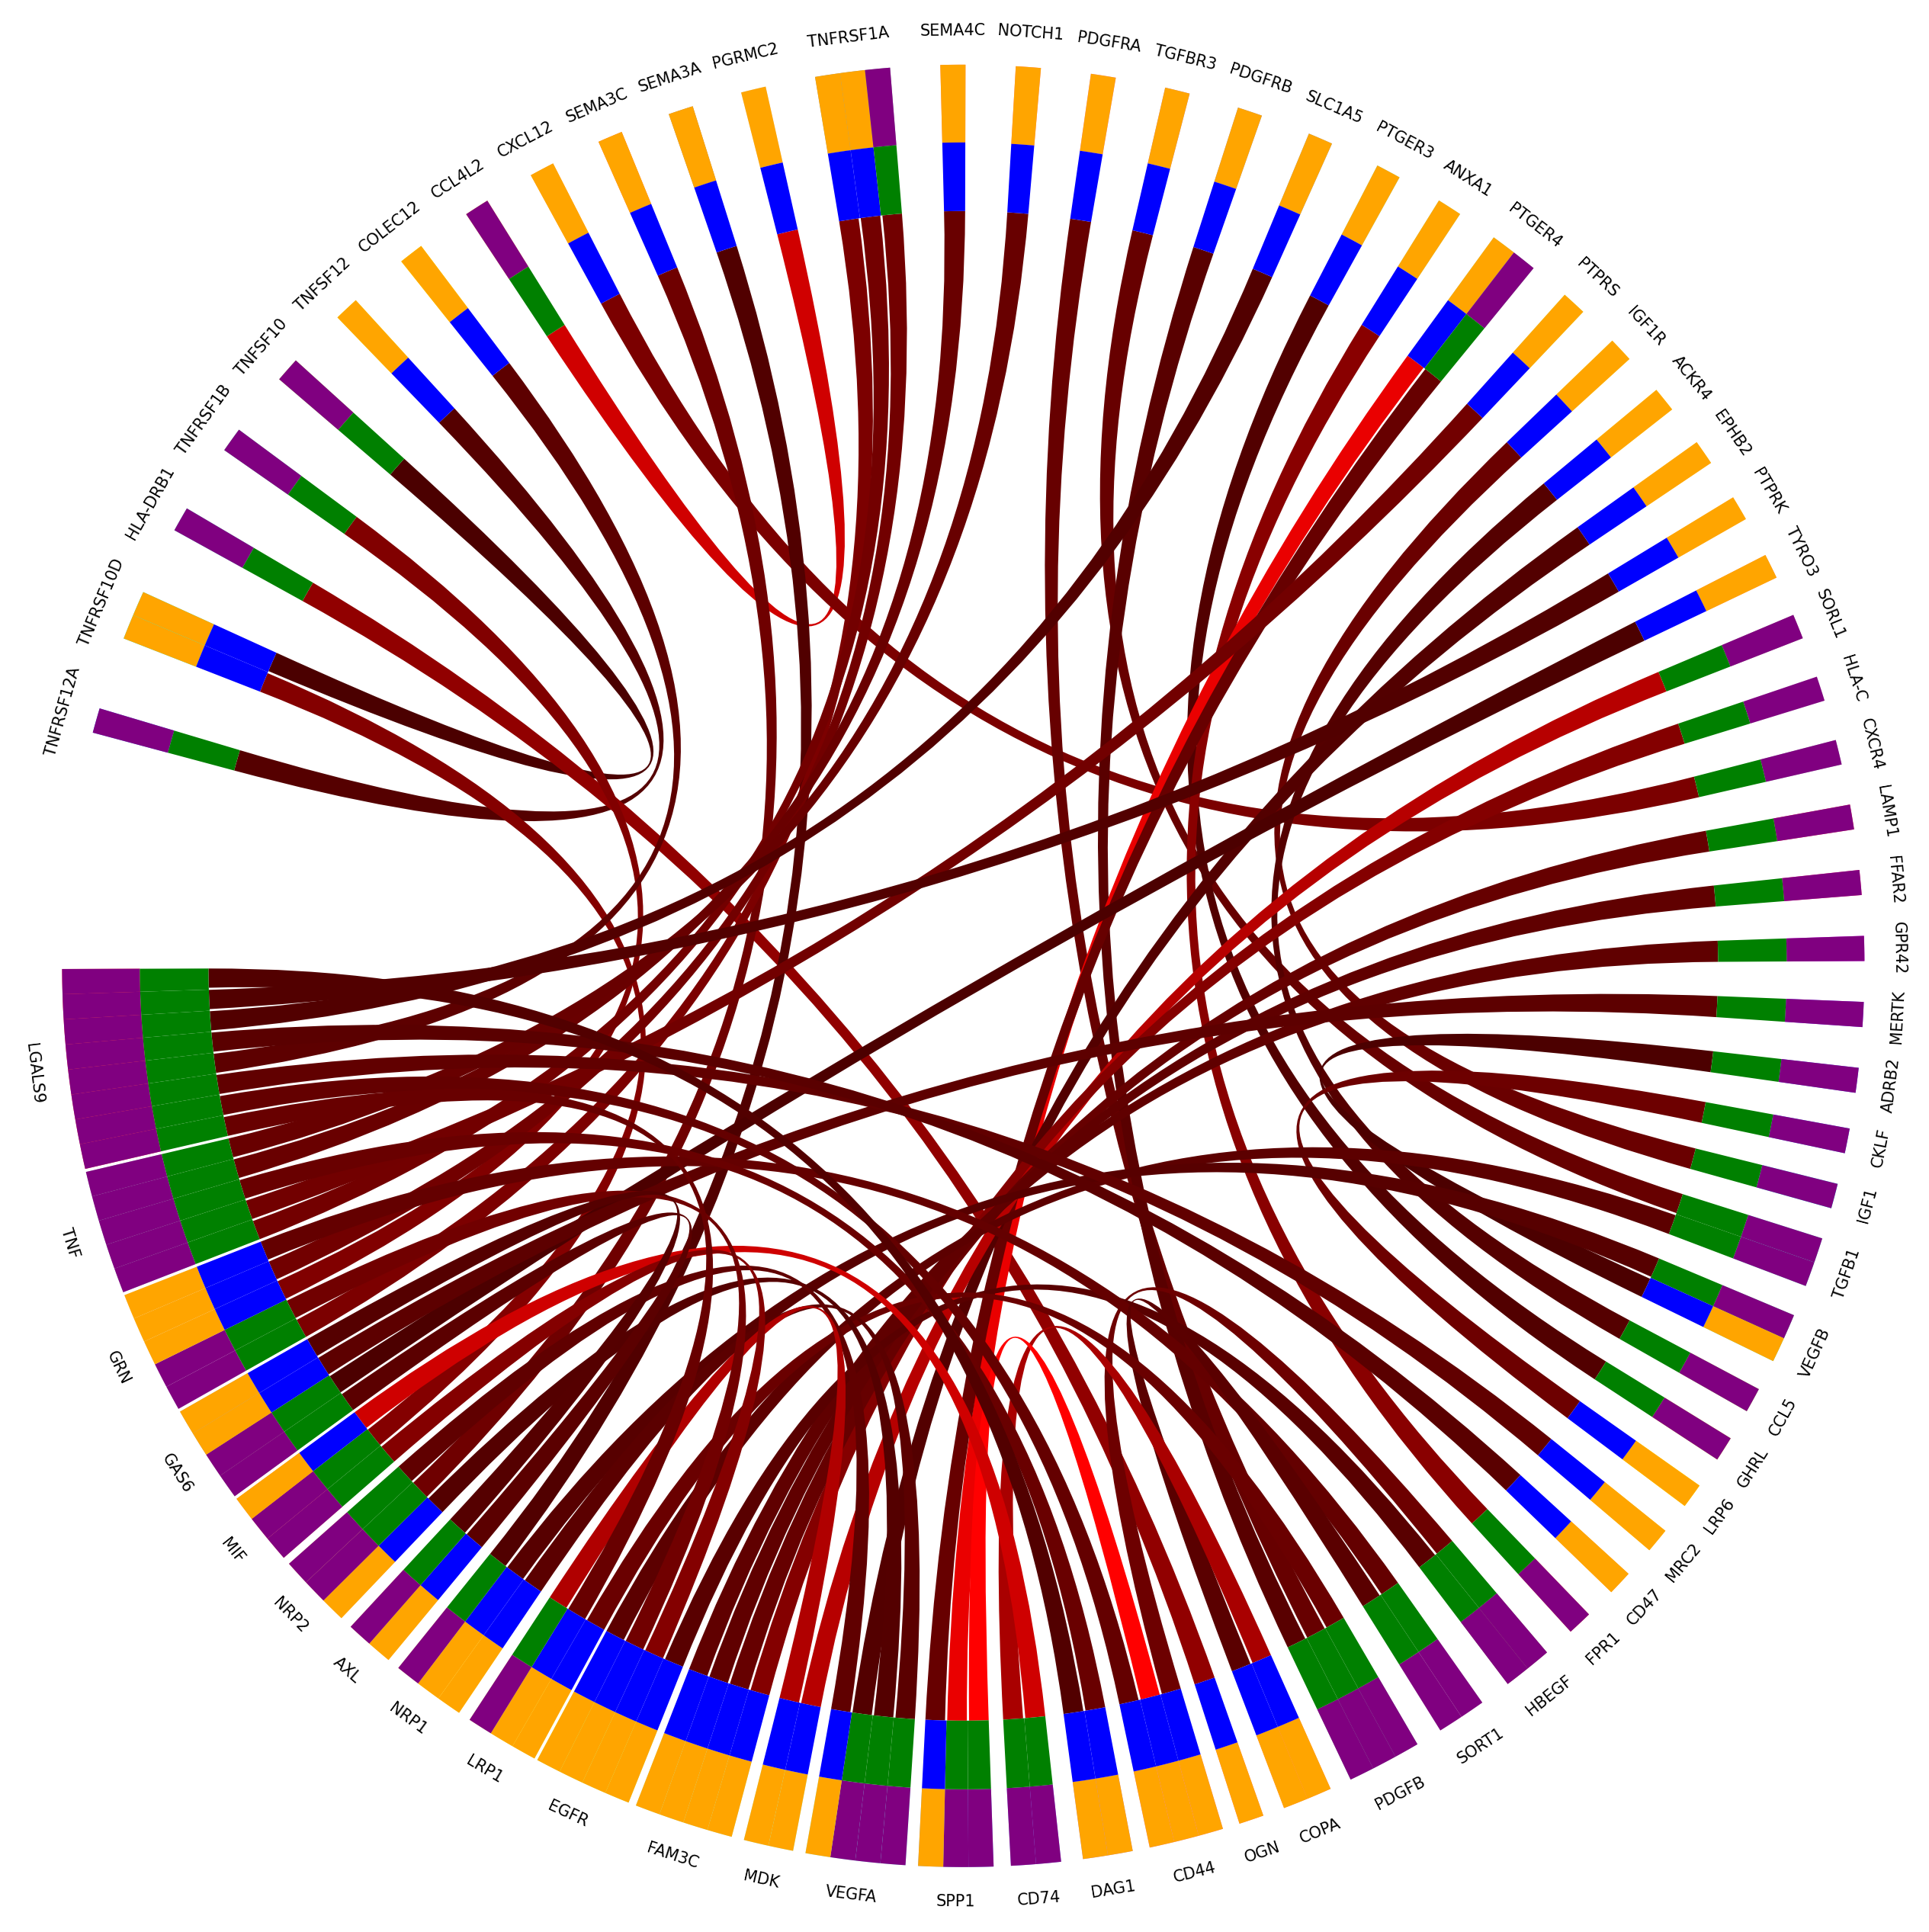

In [4380]:
circle.figure

In [4382]:
from matplotlib.colors import ListedColormap

custom_red = np.array([[i/256, 0, 0, 1] for i in range(75, 256)])
newcmp = ListedColormap(custom_red)

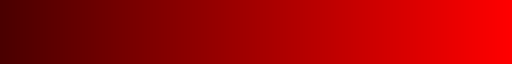

In [4383]:
newcmp

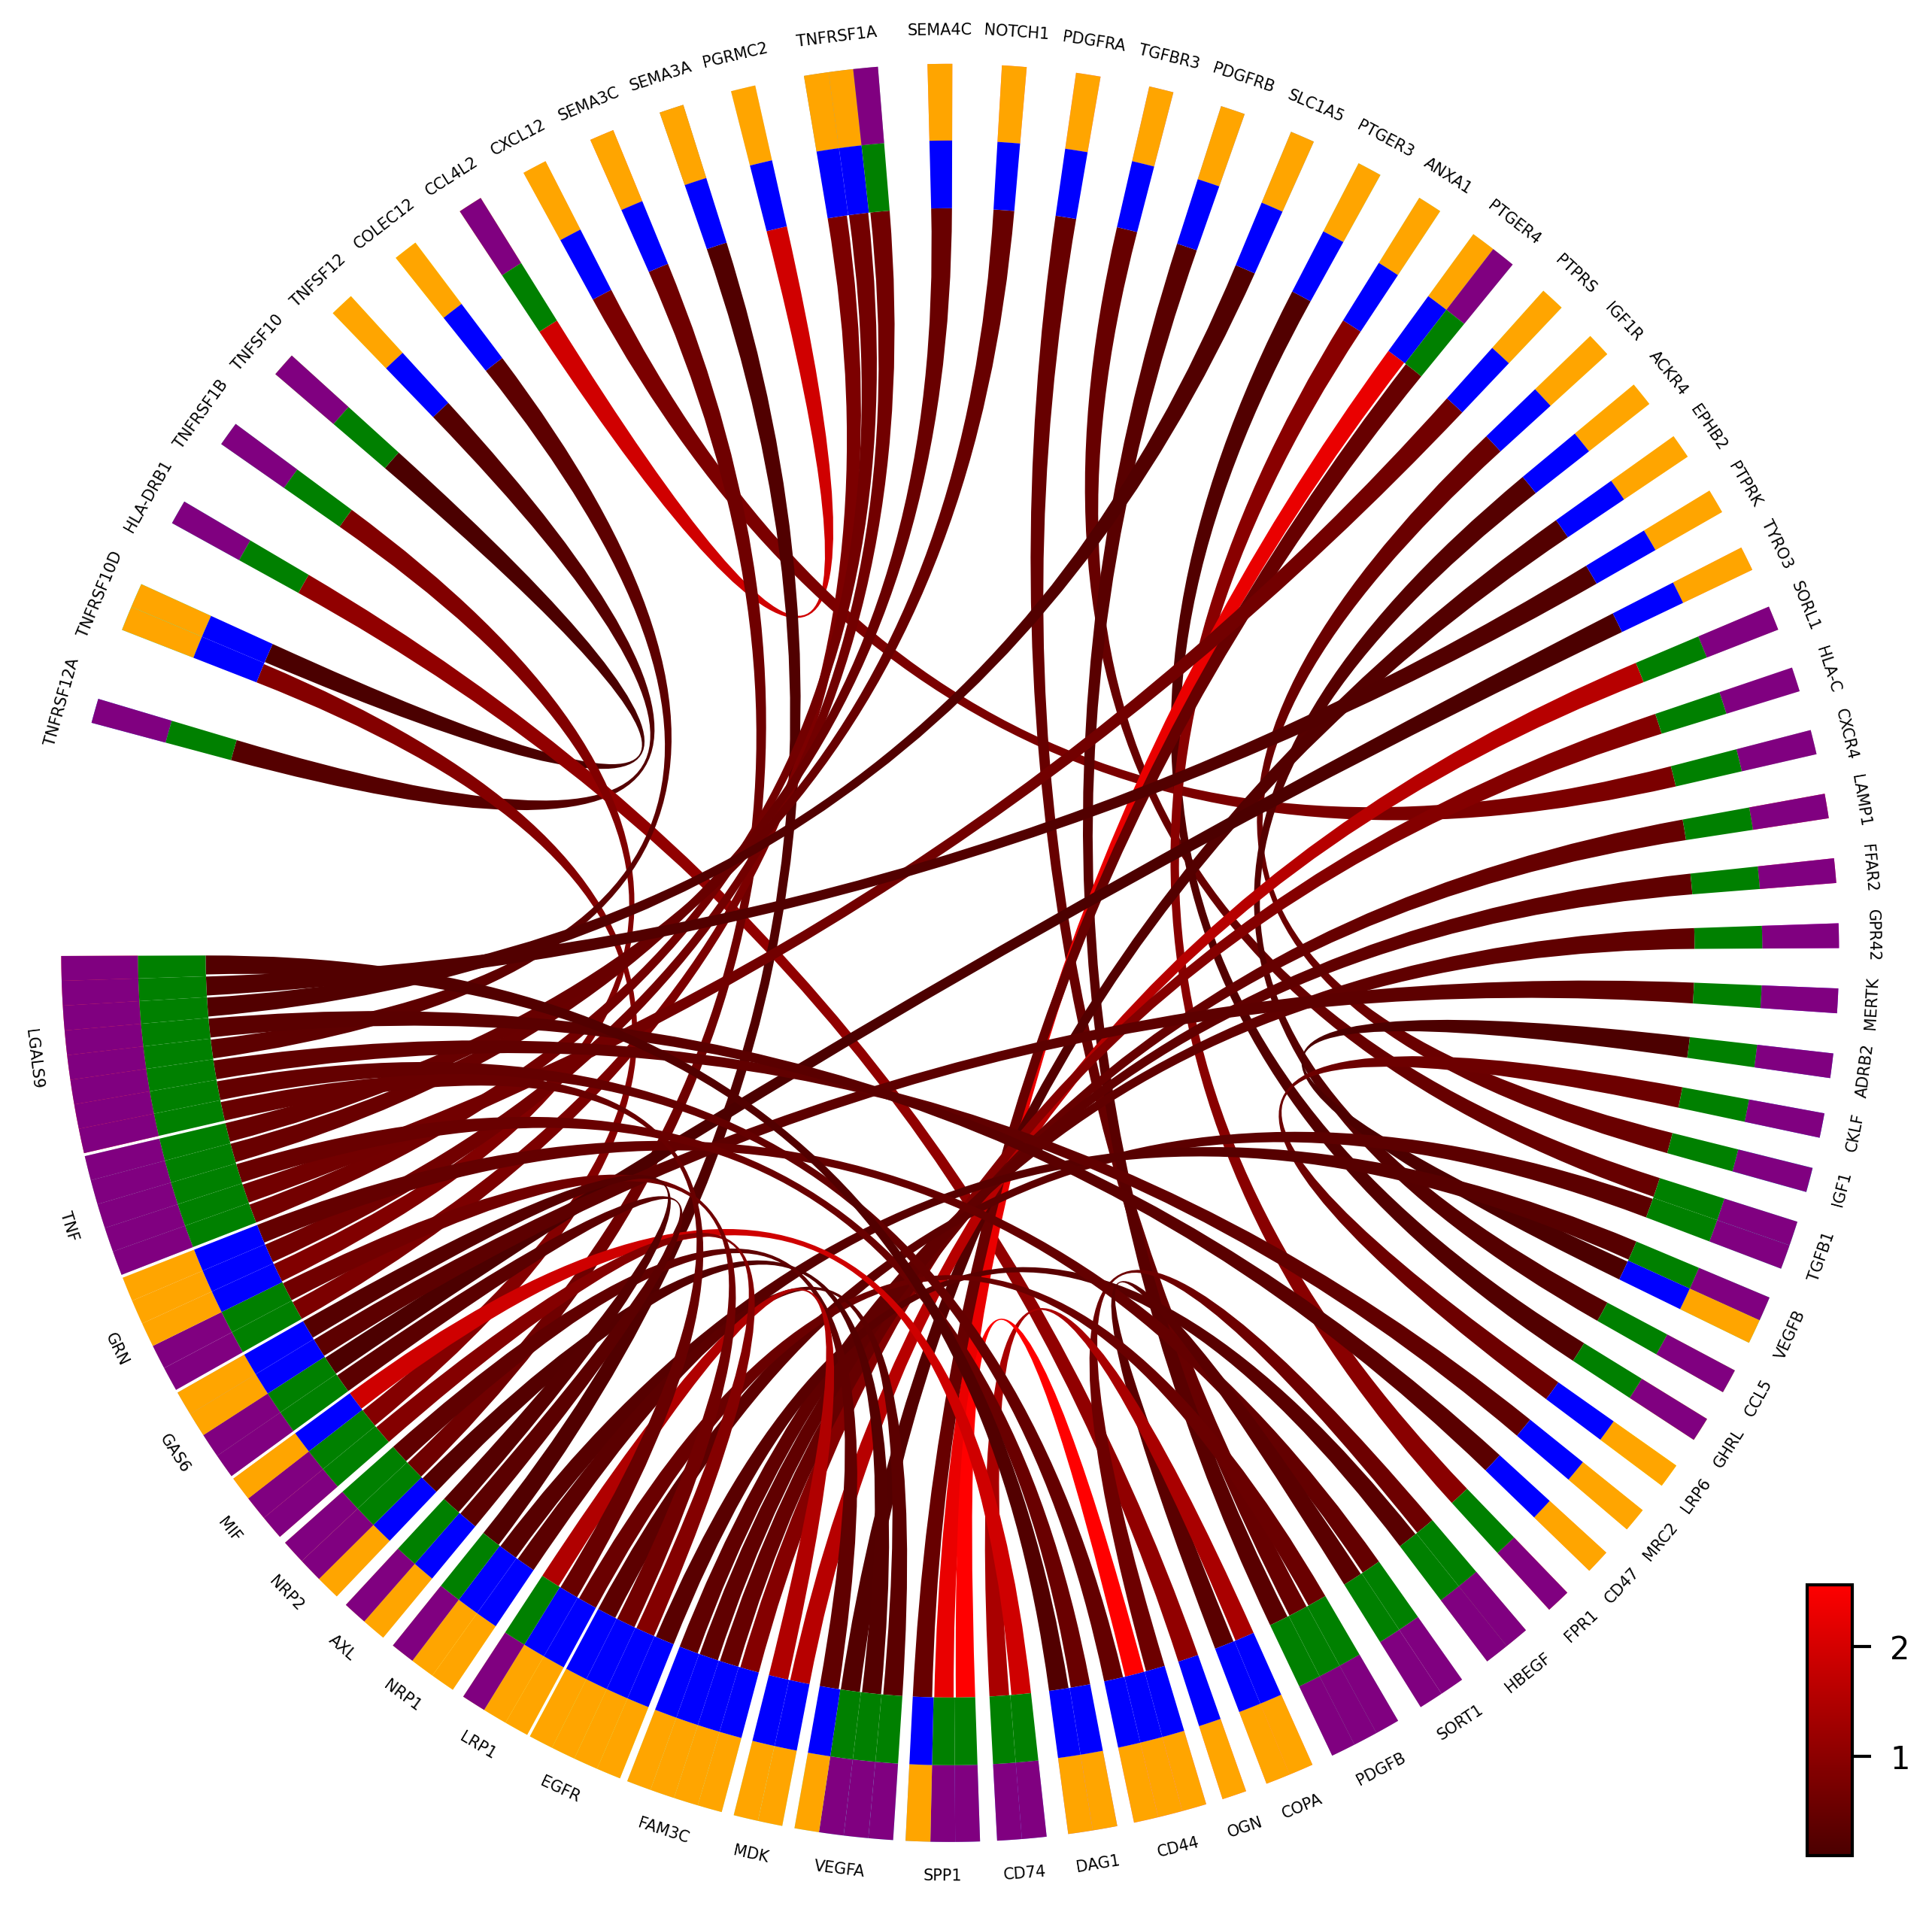

In [4384]:
import matplotlib as mpl
from matplotlib import cm

cax = [0.975, 0.0, 0.025, 0.15]
ax = circle.figure.add_axes(cax)
circle.figure.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=fca_df['mean'].min(), 
                                                                   vmax=fca_df['mean'].max()), 
                                         cmap=newcmp), 
                       cax=ax)
circle.figure

In [4387]:
circle.figure.savefig("fca_circPlot.svg")

In [ ]:
def qc_scRNASeq_anndata_by_mito_percentage(adata, mito_prefix="MT-",
                                           mito_cutoff=0.2,
                                           n_top_genes=2000,
                                           plot=True):
    """Filters out cells with high mitochondrial percentage and genes with low expression."""
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    # Filter out cells with high mitochondrial percentage
    adata = adata[adata.obs["pct_counts_mito"] < mito_cutoff, :]
    # Filter out genes with low expression
    sc.pp.filter_genes(adata, min_cells=3)
    # Normalize data
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Logarithmize data
    sc.pp.log1p(adata)
    # Scale data
    sc.pp.scale(adata, max_value=10)
    # Find highly variable genes
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
    # Filter out non-highly variable genes
    adata = adata[:, adata.var["highly_variable"]]
    # Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.regress_out(adata, ["n_counts", "pct_counts_mito"])
    # Scale data to unit variance and shift to zero mean
    sc.pp.scale(adata, max_value=10)
    # PCA
    sc.tl.pca(adata, svd_solver="arpack")
    # UMAP
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    # Plot
    if plot:
        sc.pl.umap(adata, color=["n_counts", "pct_counts_mito"], wspace=0.5)
    return adata